<h1 style='font-family:Akronim; color:slategray;' class='font-effect-fire-animation'> 🌐 Python Modules, Styling, Helpful Functions, and Links </h1>

#### [Github Version](https://github.com/OlgaBelitskaya/deep_learning_projects/tree/master/DL_PP4) & [Colaboratory Version](https://colab.research.google.com/drive/1r5yRD-3tQwN6lSql_VRoVuwQ8DaY5zUt)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Akronim|Roboto&effect=3d|fire-animation');
body {background-color:gainsboro;} 
a,h4 {color:#3636ff; font-family:Roboto;} 
span {color:indigo; text-shadow:4px 4px 4px #aaa;}
div.output_prompt,div.output_area pre {color:slategray;}
div.input_prompt,div.output_subarea {color:#3636ff;}      
div.output_stderr pre {background-color:gainsboro;}  
div.output_stderr {background-color:slategrey;}       
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import h5py,cv2,keras as ks,tensorflow as tf
import pandas as pd,numpy as np,pylab as pl
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,load_model,Model
from keras.layers import Input,Activation,Dense,LSTM
from keras.layers import Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
np.set_printoptions(precision=8)
fw='weights.style.hdf5'
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:', tf.__version__)

Using TensorFlow backend.


keras version: 2.1.5
tensorflow version: 1.7.0-rc1


In [3]:
def ohe(x): 
    return OneHotEncoder(n_values='auto')\
           .fit(x.reshape(-1,1)).transform(x.reshape(-1,1))\
           .toarray().astype('int64')
def tts(X,y): 
    x_train,x_test,y_train,y_test=\
    train_test_split(X,y,test_size=.2,random_state=1)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test
def history_plot(fit_history):
    pl.figure(figsize=(12,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='#3636ff',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='slategray',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='#3636ff',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()

<h1 style='font-family:Akronim; color:slategray;' class='font-effect-fire-animation'> 🌐 Data Loading and Preprocessing </h1>

In [4]:
N=np.random.randint(0,2000,8)
data=pd.read_csv("../input/style/style.csv")
data.iloc[N]

,brand_name,brand_label,product_name,product_label,file
242,Chanel,1,shoes,0,1_0_006.png
594,Dolce & Gabbana,2,shoes,0,2_0_014.png
68,Christian Louboutin,0,shoes,0,0_0_069.png
493,Chanel,1,ring,6,1_6_025.png
956,Gucci,3,handbag,2,3_2_018.png
1952,Yves Saint Laurent,6,lipstick,1,6_1_007.png
1465,Christian Dior,4,watches,5,4_5_045.png
1269,Christian Dior,4,lipstick,1,4_1_044.png


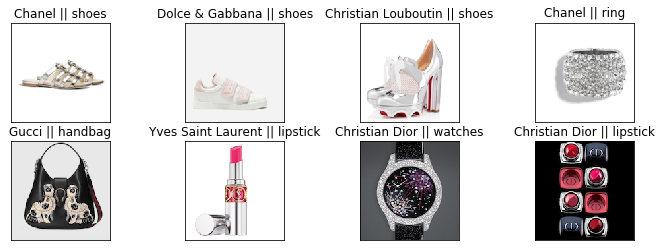

In [5]:
def display_images(img_path,ax):
    img=cv2.imread("../input/style/"+img_path)
    ax.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))    
fig=pl.figure(figsize=(12,4))
for i in range(8):
    ax=fig.add_subplot(2,4,i+1,xticks=[],yticks=[], 
                       title=data['brand_name'][N[i]]+\
                       ' || '+data['product_name'][N[i]])
    display_images(data['file'][N[i]],ax)

In [6]:
f=h5py.File('../input/StyleColorImages.h5','r')
keys=list(f.keys())
brands=np.array(f[keys[0]])
images=np.array(f[keys[1]])/255 # normalization
products=np.array(f[keys[2]])

Product:  shoes
Brand:  Versace


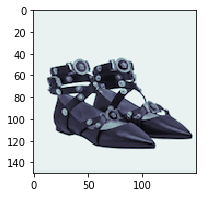

In [7]:
n=np.random.randint(0,2000,1)[0]
gray_images=np.dot(images[...,:3],[.299,.587,.114])
print('Product: ',data['product_name'][n])
print('Brand: ',data['brand_name'][n])
pl.figure(figsize=(3,3))
pl.imshow(gray_images[n],cmap=pl.cm.bone); pl.show()
gray_images=gray_images.reshape(-1,150,150,1)

In [8]:
cbrands,cproducts=ohe(brands),ohe(products)
ctargets=np.concatenate((cbrands,cproducts),axis=1)
pd.DataFrame([images.shape,gray_images.shape,
              cbrands.shape,cproducts.shape,ctargets.shape])

,0,1,2,3
0,2184,150,150.0,3.0
1,2184,150,150.0,1.0
2,2184,7,NaN,NaN
3,2184,10,NaN,NaN
4,2184,17,NaN,NaN


In [9]:
# Color Images / Products 
x_train3,x_valid3,x_test3,\
y_train3,y_valid3,y_test3=tts(images,cproducts)
# Grayscaled Images / Products 
x_train4,x_valid4,x_test4,\
y_train4,y_valid4,y_test4=tts(gray_images,cproducts)

<h1 style='font-family:Akronim; color:slategray;' class='font-effect-fire-animation'> &#x1F310; &nbsp; One-Label Classification Models </h1>

In [10]:
# Color Images, Products
def model():
    model=Sequential()
    model.add(Conv2D(32,(5,5),padding='same',
                     input_shape=x_train3.shape[1:]))
    model.add(LeakyReLU(alpha=.02))    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.2))
    model.add(Conv2D(196,(5,5)))
    model.add(LeakyReLU(alpha=.02))   
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.2))
    model.add(GlobalMaxPooling2D())   
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))     
    model.add(Dense(10))
    model.add(Activation('softmax'))   
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])    
    return model

model=model()

In [11]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.5)
estopping=EarlyStopping(monitor='val_loss',patience=16,verbose=2)
history=model.fit(x_train3,y_train3,epochs=150,batch_size=64,verbose=2,
                  validation_data=(x_valid3,y_valid3),
                  callbacks=[checkpointer,lr_reduction,estopping])

Train on 1747 samples, validate on 218 samples
Epoch 1/150
 - 15s - loss: 2.1383 - acc: 0.2164 - val_loss: 2.0388 - val_acc: 0.2844

Epoch 00001: val_loss improved from inf to 2.03884, saving model to weights.style.hdf5
Epoch 2/150
 - 2s - loss: 1.9287 - acc: 0.3017 - val_loss: 2.0654 - val_acc: 0.2661

Epoch 00002: val_loss did not improve
Epoch 3/150
 - 2s - loss: 1.8243 - acc: 0.3217 - val_loss: 2.0253 - val_acc: 0.2661

Epoch 00003: val_loss improved from 2.03884 to 2.02531, saving model to weights.style.hdf5
Epoch 4/150
 - 2s - loss: 1.7595 - acc: 0.3486 - val_loss: 1.8490 - val_acc: 0.3578

Epoch 00004: val_loss improved from 2.02531 to 1.84898, saving model to weights.style.hdf5
Epoch 5/150
 - 2s - loss: 1.6235 - acc: 0.3944 - val_loss: 1.7494 - val_acc: 0.3486

Epoch 00005: val_loss improved from 1.84898 to 1.74939, saving model to weights.style.hdf5
Epoch 6/150
 - 2s - loss: 1.5715 - acc: 0.4270 - val_loss: 1.6158 - val_acc: 0.4266

Epoch 00006: val_loss improved from 1.74939 

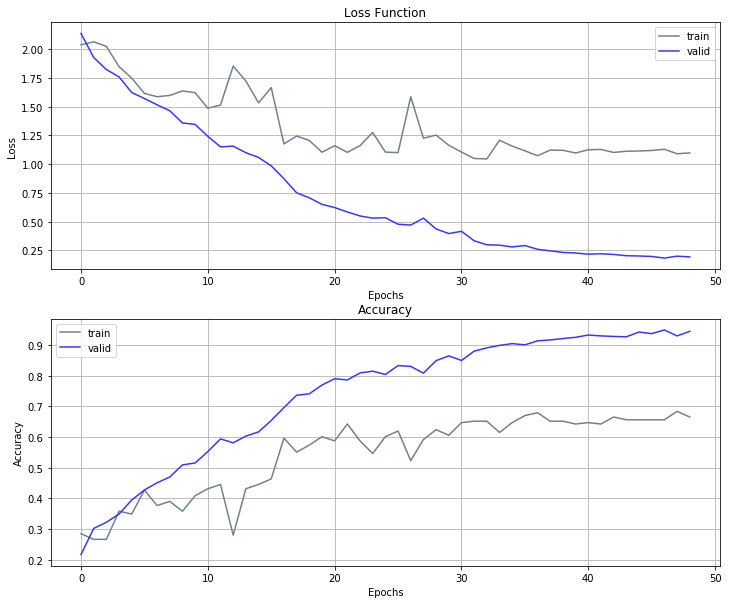

219/219 [==============================] - 0s 986us/step


[1.024006711021406, 0.7260273988932779]

In [12]:
history_plot(history)
model.load_weights(fw)
model.evaluate(x_test3,y_test3)

In [13]:
# Grayscaled Images, Products
def gray_model():
    model=Sequential()
    model.add(Conv2D(32,(5,5),padding='same',
                     input_shape=x_train4.shape[1:]))
    model.add(LeakyReLU(alpha=.02))    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.2))
    model.add(Conv2D(196,(5,5)))
    model.add(LeakyReLU(alpha=.02))    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.2))
    model.add(GlobalMaxPooling2D())    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))    
    model.add(Dense(10))
    model.add(Activation('softmax'))   
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',metrics=['accuracy'])    
    return model
gray_model=gray_model()

In [14]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,
                               verbose=2,factor=.5)
estopping=EarlyStopping(monitor='val_loss',patience=16,verbose=2)
history=gray_model.fit(x_train4,y_train4,epochs=150,batch_size=64,
                       verbose=2,validation_data=(x_valid4,y_valid4),
                       callbacks=[checkpointer,lr_reduction,estopping])

Train on 1747 samples, validate on 218 samples
Epoch 1/150
 - 3s - loss: 2.1856 - acc: 0.2061 - val_loss: 2.1358 - val_acc: 0.3303

Epoch 00001: val_loss improved from inf to 2.13577, saving model to weights.style.hdf5
Epoch 2/150
 - 2s - loss: 2.0016 - acc: 0.2456 - val_loss: 2.0157 - val_acc: 0.3165

Epoch 00002: val_loss improved from 2.13577 to 2.01567, saving model to weights.style.hdf5
Epoch 3/150
 - 2s - loss: 1.8571 - acc: 0.3457 - val_loss: 1.8378 - val_acc: 0.3991

Epoch 00003: val_loss improved from 2.01567 to 1.83781, saving model to weights.style.hdf5
Epoch 4/150
 - 2s - loss: 1.7578 - acc: 0.3686 - val_loss: 1.7962 - val_acc: 0.3899

Epoch 00004: val_loss improved from 1.83781 to 1.79621, saving model to weights.style.hdf5
Epoch 5/150
 - 2s - loss: 1.6572 - acc: 0.4224 - val_loss: 1.7428 - val_acc: 0.3532

Epoch 00005: val_loss improved from 1.79621 to 1.74283, saving model to weights.style.hdf5
Epoch 6/150
 - 2s - loss: 1.6010 - acc: 0.4367 - val_loss: 1.7243 - val_acc: 

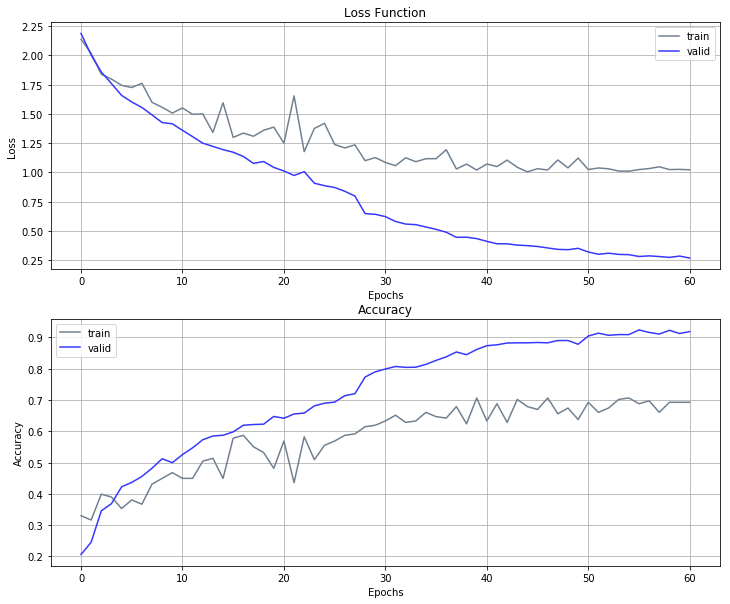

219/219 [==============================] - 0s 489us/step


[1.0484553570072401, 0.6849315057606458]

In [15]:
history_plot(history)
gray_model.load_weights(fw)
gray_model.evaluate(x_test4,y_test4)